<h4>I used Claude, Anthropic's model to help with the code portion of this assignment.</h4>
<h4>I used Copilot for help understanding these concepts.</h4>

<h3>1) Collect data from a reputable source in order use both a simple regression and multiple regression to make prediction and generate prediction intervals in a Colab notebook. You can collect multiple independent variables, or you can "make" the extra independent variable by using a time trend like the video, interactions, or categorical variables. Do not use simulated data for this assignment. Motivate your analysis by explaining why someone might be interested in predicting the dependent variable you use. Please reach out to me if you need to brainstorm data to collect. Come up with some interesting sets of independent variables to make predictions with, and present both the point prediction and associated prediction interval.</h3>


<p>I found a dataset a kaggle user put together by scraping online forms for job postings related to data science.</p>
<a href="https://www.kaggle.com/datasets/elahehgolrokh/data-science-job-postings-with-salaries-2025">2025 Data Science Job Postings</a>

<ul>
<li>job_title → The main keyword in the title of the posted position (e.g., Data Scientist, ML Engineer).
</li>
<li>seniority_level → Seniority of the role (e.g., Junior, Senior, Lead).
</li>
<li>status → Work arrangement type (Remote, Hybrid, On-site).
</li>
<li>company → Anonymized company identifier.
</li>
<li>location → Job location(s) mentioned in the posting.
</li>
<li>post_date → When the job posting was listed.
</li>
<li>headquarter → Location of the company’s headquarters.
</li>
<li>industry → Industry sector of the company (e.g., Finance, Technology).
</li>
<li>ownership → Ownership type (e.g., Public, Private).
</li>
<li>company_size → Number of employees in the company.
</li>
<li>revenue → Reported revenue of the company (if available).
</li>
<li>salary → Annual salary in Euro, expressed as min-max or a single value
</li>
<li>skills → Extracted list of required or preferred skills (e.g., Python, SQL, Spark).</li>
</ul>

<p>We all have a job for one reason and that's money. If you don't work for money you're a lucky person, but for most, money is why we show up to our jobs.</p>
<p>Due to this reason I thought it would be intresting to make my dependent variable salary for data science jobs. </p>

In [22]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder



In [23]:
df = pd.read_csv('../datasets/assignment8/data_science_job_posts_2025.csv')

In [24]:
# Sample exchange rate (you can update this dynamically)
EUR_TO_USD = 1.17

def convert_revenue(value):
    value = str(value)  # Ensure it's a string
    match = re.match(r'€([\d\.]+)([MBT])', value)
    if match:
        num, unit = match.groups()
        multiplier = {'M': 1e6, 'B': 1e9, 'T': 1e12}[unit]
        usd_value = float(num) * multiplier * EUR_TO_USD
        return f"${usd_value:,.2f}"
    return value  # Return original if not matching

def convert_salary(value):
    value = str(value)  # Ensure it's a string
    parts = re.findall(r'€[\d,]+', value)
    if parts:
        converted = []
        for part in parts:
            num = float(part.replace('€', '').replace(',', ''))
            usd = num * EUR_TO_USD
            converted.append(f"${usd:,.0f}")
        return " - ".join(converted)
    return value

df['revenue'] = df['revenue'].fillna("").apply(convert_revenue)
df['salary'] = df['salary'].fillna("").apply(convert_salary)
df = df[df['company_size'].astype(str).str.match(r'^[\d,]+$')] # I lost 40 rows since company size had erroneous euro signs and I didn't want to regex them...

df = df.drop('company', axis=1)

df.head(5)


,job_title,seniority_level,status,location,post_date,headquarter,industry,ownership,company_size,revenue,salary,skills
1,data scientist,lead,hybrid,"Fort Worth, TX . Hybrid",15 days ago,"Detroit, MI, US",Manufacturing,Public,"155,030","$59,787,000,000.00","$138,918","['spark', 'r', 'python', 'sql', 'machine learn..."
2,data scientist,senior,on-site,"Austin, TX . Toronto, Ontario, Canada . Kirkla...",a month ago,"Redwood City, CA, US",Technology,Public,"25,930","$39,546,000,000.00","$111,135 - $186,684","['aws', 'git', 'python', 'docker', 'sql', 'mac..."
3,data scientist,senior,hybrid,"Chicago, IL . Scottsdale, AZ . Austin, TX . Hy...",8 days ago,"San Jose, CA, US",Technology,Public,"34,690","$95,600,700,000.00","$131,972 - $227,450","['sql', 'r', 'python']"
4,data scientist,NaN,on-site,On-site,3 days ago,"Stamford, CT, US",Finance,Private,"1,800",Private,"$133,581 - $267,154",[]
5,data scientist,lead,NaN,"New York, NY",3 months ago,"New York, NY, US",Technology,Private,150,"$2,527,200,000.00","$229,754 - $293,869","['scikit-learn', 'python', 'scala', 'sql', 'ma..."


In [25]:
# prints me unique id in a column
for val in df['job_title'].unique():
    print(val)

print('\n')
# df.nunique()
# df.info()
print( df.info(), df.nunique())

data scientist
machine learning engineer
nan
data analyst
data engineer


<class 'pandas.core.frame.DataFrame'>
Index: 905 entries, 1 to 943
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   job_title        902 non-null    object
 1   seniority_level  845 non-null    object
 2   status           650 non-null    object
 3   location         903 non-null    object
 4   post_date        905 non-null    object
 5   headquarter      905 non-null    object
 6   industry         905 non-null    object
 7   ownership        873 non-null    object
 8   company_size     905 non-null    object
 9   revenue          905 non-null    object
 10  salary           905 non-null    object
 11  skills           905 non-null    object
dtypes: object(12)
memory usage: 91.9+ KB
None job_title            4
seniority_level      4
status               3
location           411
post_date           42
headquarter        194
industry   

In [26]:
# salary would be th eobvious one. tbh that is interesting. Since if I predict the salary then depending on the industry you can see which salarys are fat.
# time to graph some things.

salary = beta_0 + beta_1*industry + beta_2*job_title + beta_3*location + beta_4*company_size... every single column seems useful. I just gotta preprocess it. But Now I know that salary is my dependent variable.


In [27]:

# --- Helper functions ---

def clean_salary(salary_str):
    """Convert salary column (single value or range) to numeric midpoint."""
    if pd.isna(salary_str):
        return np.nan
    # Remove dollar signs, commas
    s = salary_str.replace("$", "").replace(",", "")
    # Handle ranges
    if "-" in s:
        low, high = s.split("-")
        return (float(low) + float(high)) / 2
    try:
        return float(s)
    except:
        return np.nan

def clean_revenue(rev_str):
    """Convert revenue string with $ and commas to numeric float."""
    if pd.isna(rev_str):
        return np.nan
    s = rev_str.replace("$", "").replace(",", "")
    try:
        return float(s)
    except:
        return np.nan

def days_since_posting(post_date_str):
    """Convert relative dates like '15 days ago', 'a month ago', '2 years ago' to days."""
    if pd.isna(post_date_str):
        return np.nan
    text = post_date_str.lower()

    # Look for a number
    nums = re.findall(r'\d+', text)

    if "day" in text and nums:
        return int(nums[0])
    elif "day" in text:
        return 1  # "a day ago"
    elif "month" in text and nums:
        return int(nums[0]) * 30
    elif "month" in text:
        return 30  # "a month ago"
    elif "year" in text and nums:
        return int(nums[0]) * 365
    elif "year" in text:
        return 365  # "a year ago"
    else:
        return np.nan
    
def extract_state(location_str):
    """Extract state (US) or country for simplification."""
    if pd.isna(location_str):
        return None
    # Take the first part before a '.' if multiple locations
    loc = location_str.split(".")[0].strip()
    # Grab last part (state abbreviation or country)
    parts = loc.split(",")
    if len(parts) > 1:
        return parts[-1].strip()
    return loc.strip()

def midpoint_company_size(size_val):
    """If company size is a range, take midpoint. Otherwise return numeric."""
    if pd.isna(size_val):
        return np.nan
    try:
        return float(size_val)
    except:
        # e.g., "51-200"
        if "-" in str(size_val):
            low, high = str(size_val).split("-")
            return (float(low) + float(high)) / 2
    return np.nan


In [28]:

# Salary -> numeric
df["salary_num"] = df["salary"].apply(clean_salary)

# Revenue -> numeric
df["revenue_num"] = df["revenue"].apply(clean_revenue)

# Company size -> numeric
df["company_size_num"] = df["company_size"].apply(midpoint_company_size)

# Post date -> numeric days
df["days_since_post"] = df["post_date"].apply(days_since_posting)

# Location -> state/country
df["job_state"] = df["location"].apply(extract_state)

# Headquarter -> state/country
df["hq_state"] = df["headquarter"].apply(extract_state)

# Skills -> turn into binary skill indicators
# Flatten list of skills
all_skills = set()
df["skills"] = df["skills"].apply(lambda x: eval(x) if isinstance(x, str) and x.startswith("[") else [])
df["skills"].apply(lambda skill_list: all_skills.update(skill_list))
all_skills = list(all_skills)

for skill in all_skills:
    df[f"skill_{skill.lower()}"] = df["skills"].apply(lambda x: 1 if skill in x else 0)
# Define column groups
categorical_cols = ["job_title", "seniority_level", "status", "job_state", "hq_state", "industry", "ownership"]
numeric_cols = ["company_size_num", "revenue_num", "days_since_post"]

# Preprocessing pipeline with imputation
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_cols),
        
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_cols),
    ],
    remainder="drop"
)

# Full pipeline
model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("regressor", LinearRegression())
])


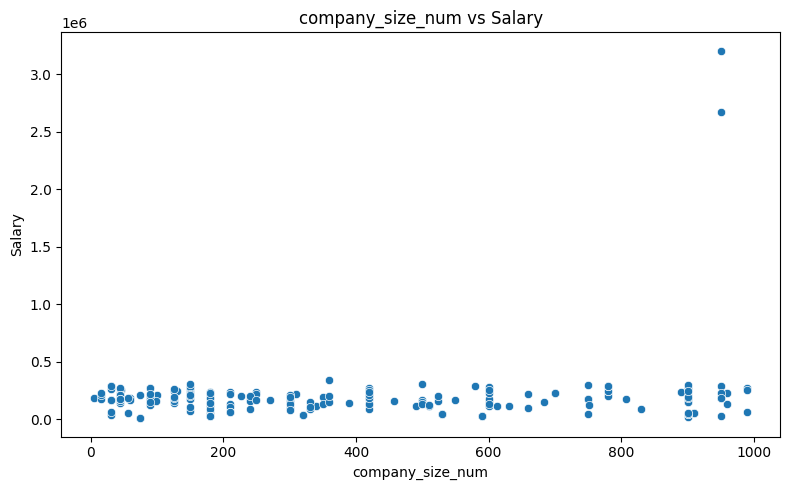

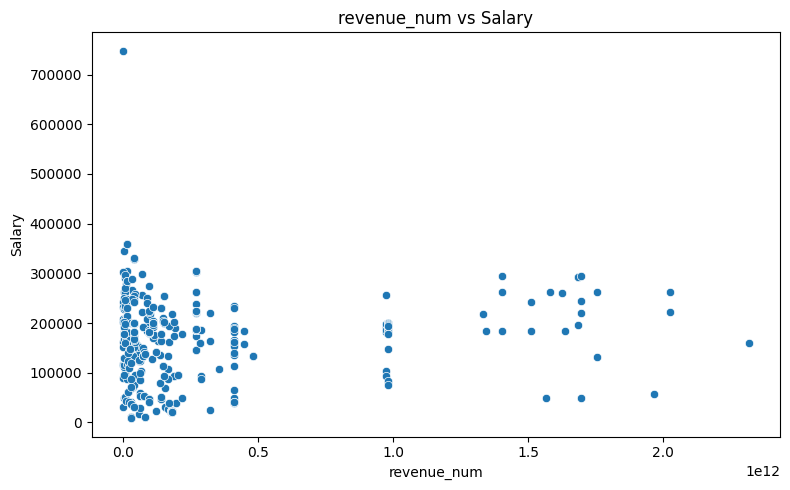

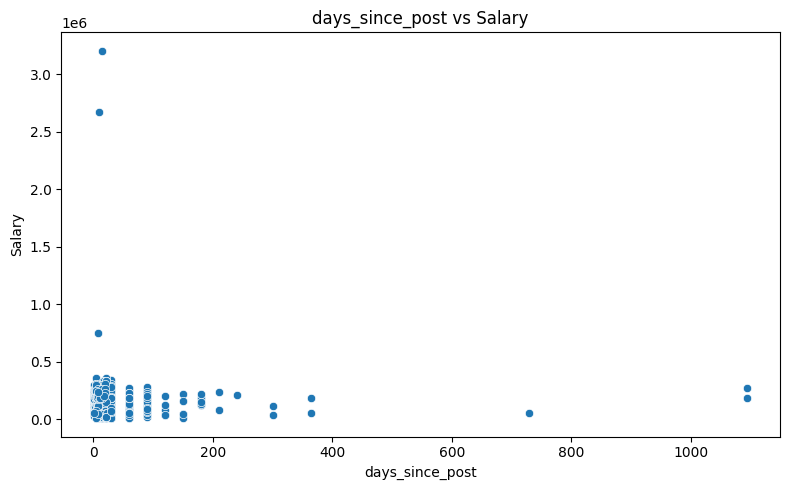

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ["company_size_num", "revenue_num", "days_since_post"]

for col in numeric_cols:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=df[col], y=df["salary_num"])
    plt.title(f"{col} vs Salary")
    plt.xlabel(col)
    plt.ylabel("Salary")
    plt.tight_layout()
    plt.show()



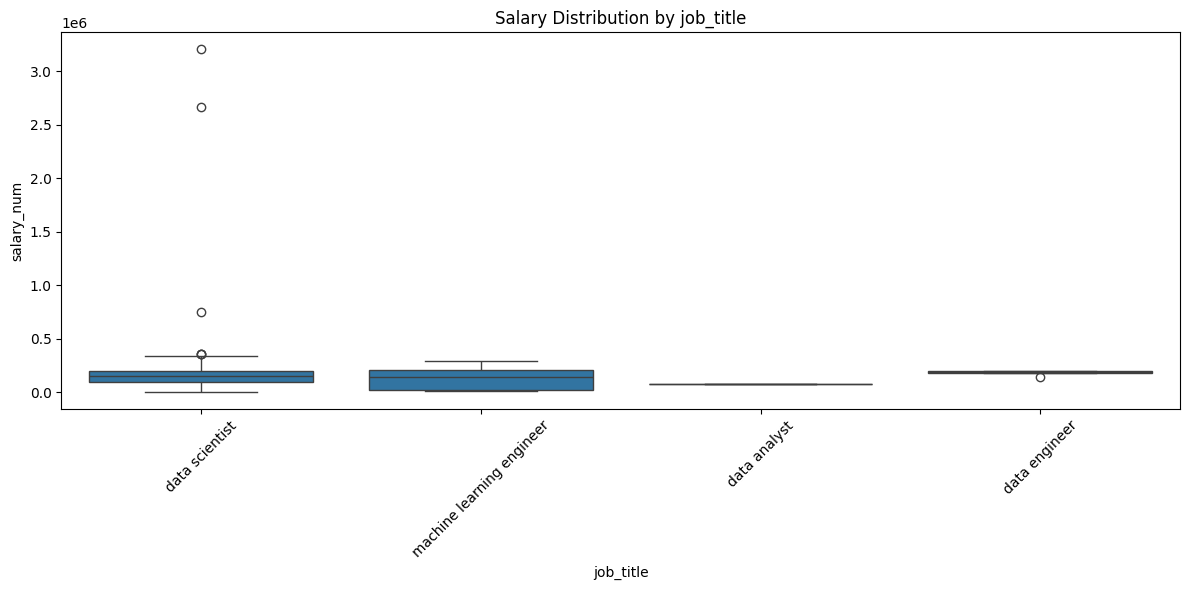

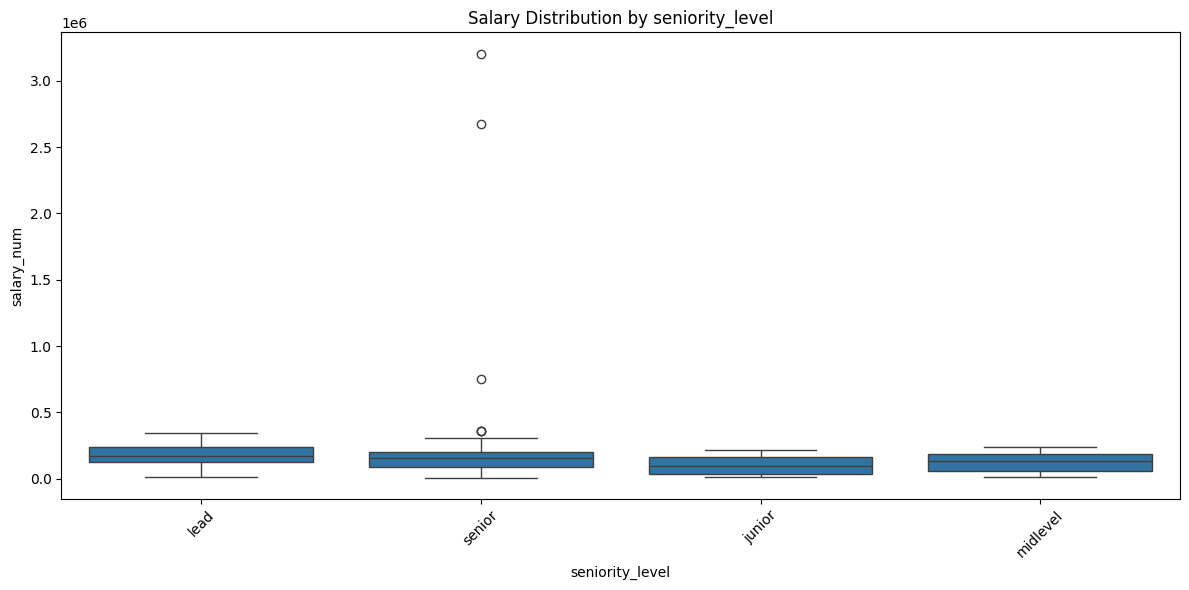

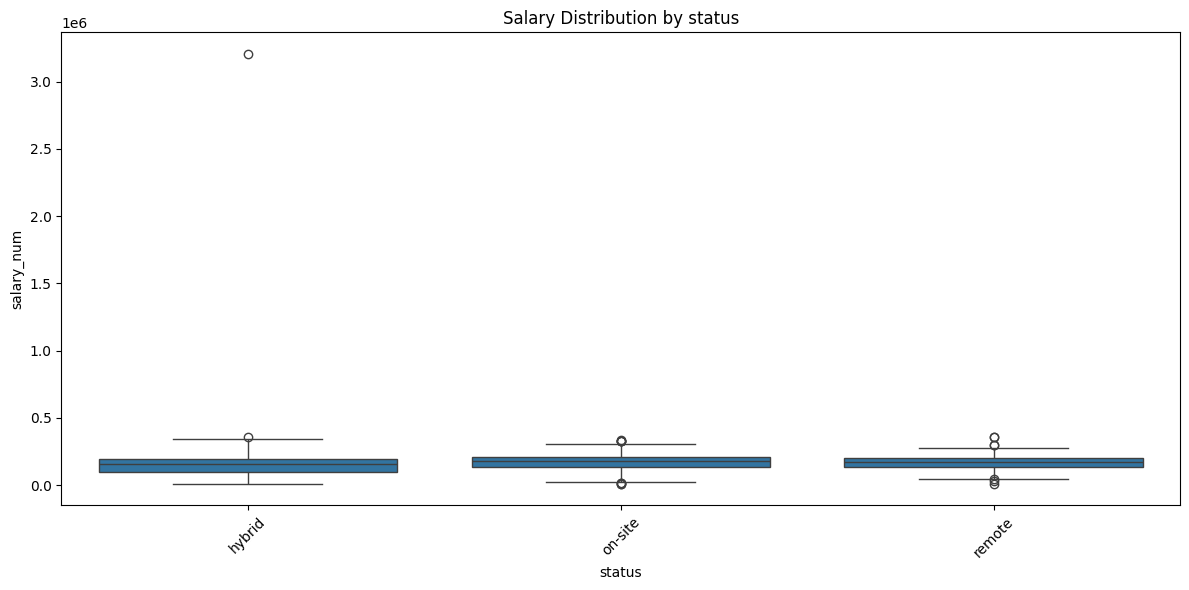

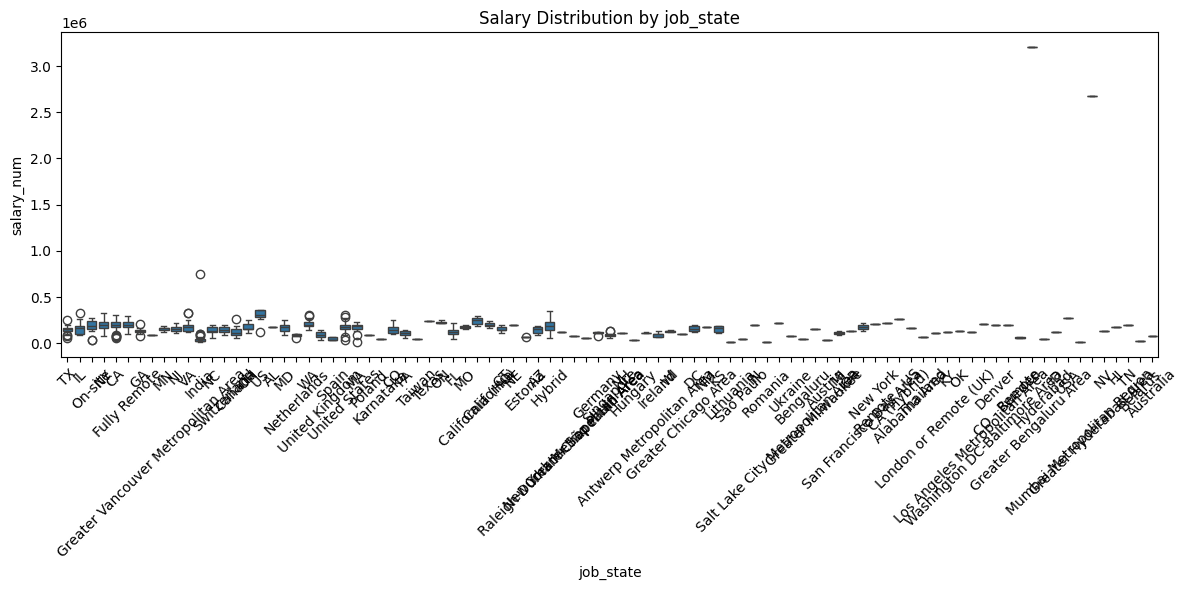

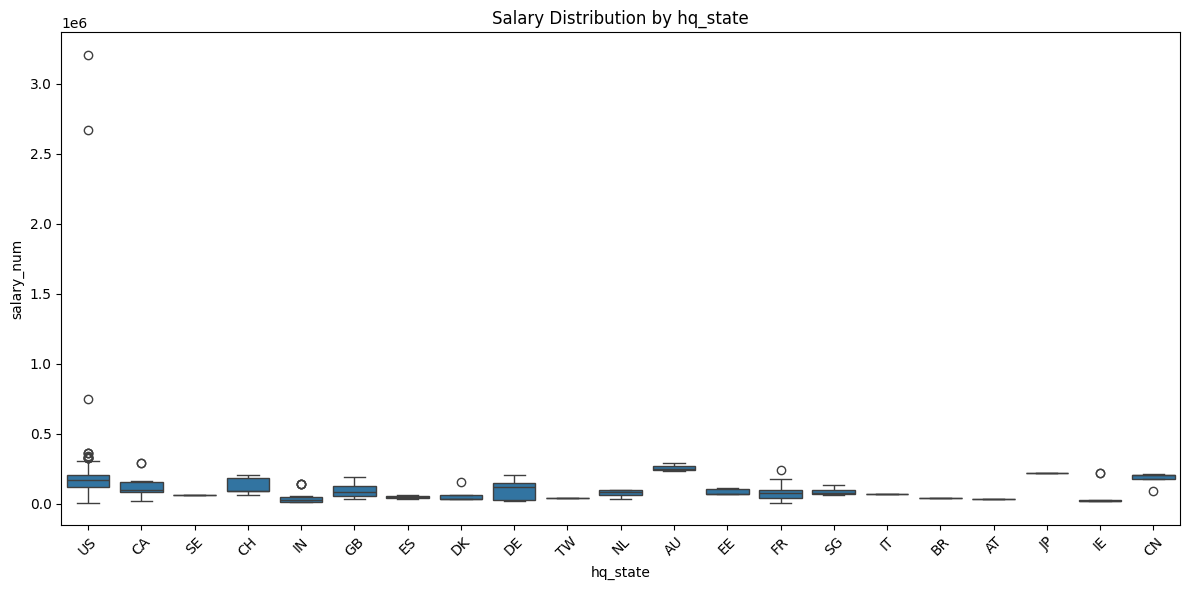

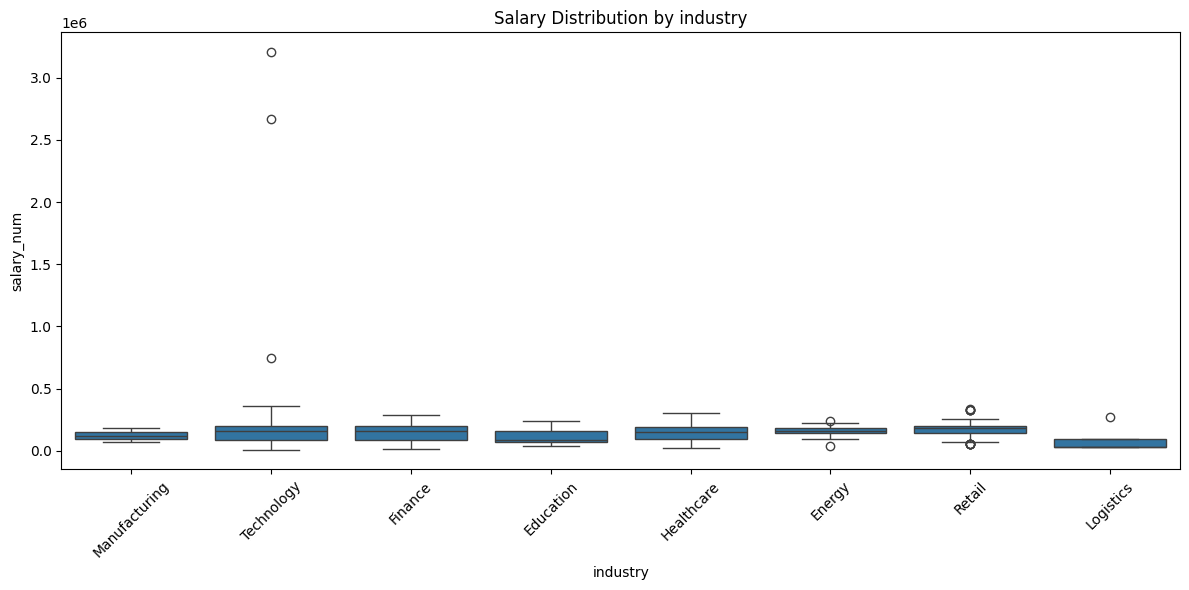

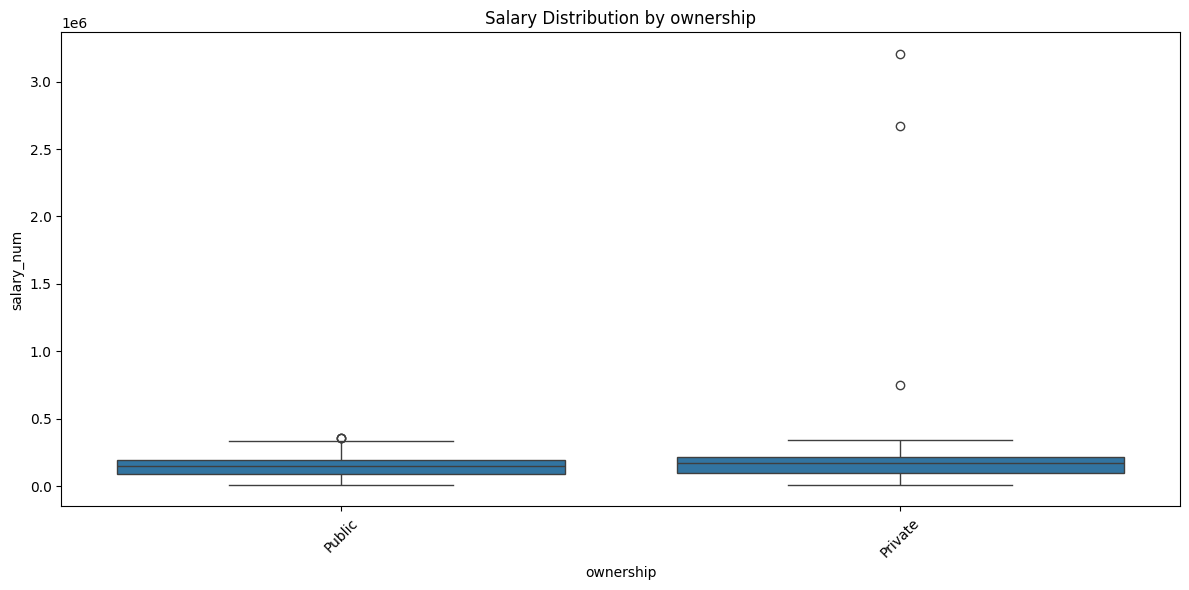

In [30]:
categorical_cols = ["job_title", "seniority_level", "status", "job_state", "hq_state", "industry", "ownership"]

for col in categorical_cols:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df[col], y=df["salary_num"])
    plt.xticks(rotation=45)
    plt.title(f"Salary Distribution by {col}")
    plt.tight_layout()
    plt.show()


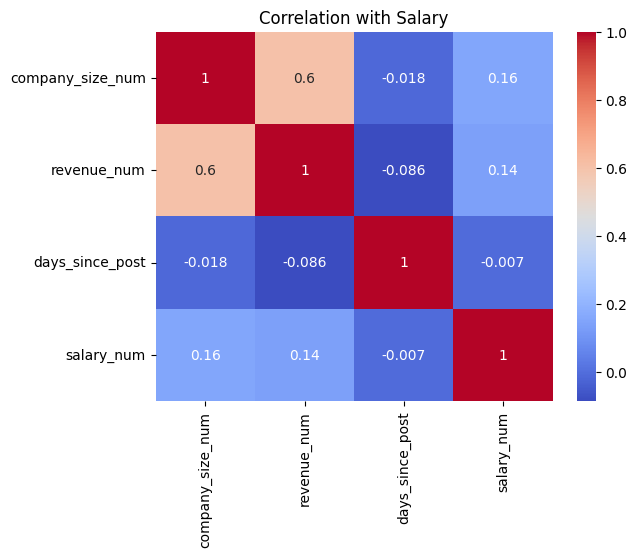

In [31]:
corr = df[numeric_cols + ["salary_num"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation with Salary")
plt.show()


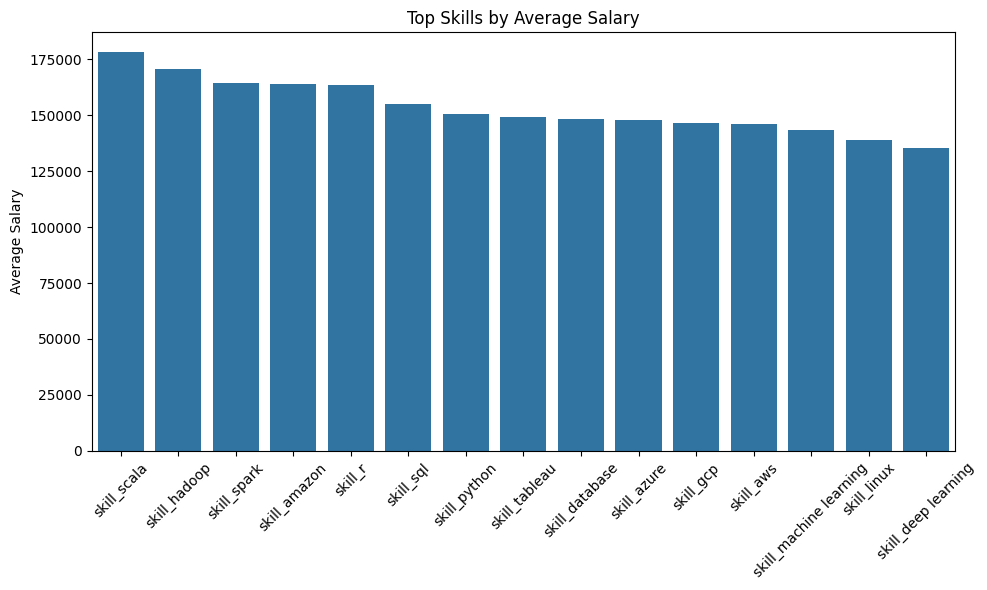

In [32]:
skill_cols = [col for col in df.columns if col.startswith("skill_")]

skill_avg_salary = {
    skill: df[df[skill] == 1]["salary_num"].mean()
    for skill in skill_cols
}

# Sort and plot top 15
top_skills = sorted(skill_avg_salary.items(), key=lambda x: x[1], reverse=True)[:15]
skills, salaries = zip(*top_skills)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(skills), y=list(salaries))
plt.xticks(rotation=45)
plt.title("Top Skills by Average Salary")
plt.ylabel("Average Salary")
plt.tight_layout()
plt.show()


In [33]:
# Drop rows where salary is NaN (cannot train without target)
df = df[~df["salary_num"].isna()].copy()

X = df[categorical_cols + numeric_cols + [col for col in df.columns if col.startswith("skill_")]]
y = df["salary_num"]

model.fit(X, y)

df.head(5)

,job_title,seniority_level,status,location,post_date,headquarter,industry,ownership,company_size,revenue,...,skill_hadoop,skill_tableau,skill_java,skill_airflow,skill_powerbi,skill_tensorflow,skill_python,skill_azure,skill_keras,skill_linux
1,data scientist,lead,hybrid,"Fort Worth, TX . Hybrid",15 days ago,"Detroit, MI, US",Manufacturing,Public,"155,030","$59,787,000,000.00",...,0,0,0,0,0,0,1,0,0,0
2,data scientist,senior,on-site,"Austin, TX . Toronto, Ontario, Canada . Kirkla...",a month ago,"Redwood City, CA, US",Technology,Public,"25,930","$39,546,000,000.00",...,0,0,0,0,0,0,1,0,0,0
3,data scientist,senior,hybrid,"Chicago, IL . Scottsdale, AZ . Austin, TX . Hy...",8 days ago,"San Jose, CA, US",Technology,Public,"34,690","$95,600,700,000.00",...,0,0,0,0,0,0,1,0,0,0
4,data scientist,NaN,on-site,On-site,3 days ago,"Stamford, CT, US",Finance,Private,"1,800",Private,...,0,0,0,0,0,0,0,0,0,0
5,data scientist,lead,NaN,"New York, NY",3 months ago,"New York, NY, US",Technology,Private,150,"$2,527,200,000.00",...,0,0,0,0,0,1,1,0,0,0


In [34]:
# todo
# show the data after all of the preprocessing and see if it is autoregressive, or variance is bad, or I guess I can say it assumes BLUE and staionarity...


In [35]:
# 1. Fit preprocessor and transform X
X_transformed = preprocessor.fit_transform(X)

# 2. Convert to dense if sparse
if hasattr(X_transformed, "toarray"):
    X_transformed = X_transformed.toarray()

# 3. Add intercept
X_sm = sm.add_constant(X_transformed)

# 4. Get exact feature names from preprocessor
feature_names = ["const"] + preprocessor.get_feature_names_out().tolist()

# 5. Build DataFrame
X_df = pd.DataFrame(X_sm, columns=feature_names)

# 6. Fit OLS regression
ols_model = sm.OLS(y.values, X_df).fit()

print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     61.66
Date:                Mon, 06 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:41:57   Log-Likelihood:                -10983.
No. Observations:                 905   AIC:                         2.223e+04
Df Residuals:                     773   BIC:                         2.287e+04
Df Model:                         131                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

<h3>(2) Make a plot showing the predicted regression line from your simple regression with the dependent variable on the y-axis and independent variable on the x-axis. Also display prediction interval lines. (The easiest way to do this is probably starting by generating x-values from x-min to x-max, then getting predicted y's for that set. Then generate lower and upper prediction interval bounds for each x in the set. Note that the statistics, e.g., /bar{x}, should still be calculated using the collected data.)</h3>

In [36]:
# todo